In [13]:
import os
import jax
import jax.numpy as jnp
import flax.nnx as nnx
import optax, orbax
from collections import Counter
from dataclasses import dataclass
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import numpy as np
import tiktoken, time, wandb

In [14]:
### Alternative data and model parallel
# mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

mesh = Mesh(mesh_utils.create_device_mesh((1, 1)), ('batch', 'model'))

In [15]:
tokenizer = tiktoken.get_encoding("gpt2")

In [16]:
vocab_size = tokenizer.n_vocab
GPT2_variant = "GPT2" # "GPT2-medium"
if GPT2_variant == "GPT2-medium":
    num_transformer_blocks = 24
    seqlen = 1024
    embed_dim = 1024
    num_heads = 16
    feed_forward_dim = 4 * embed_dim
    batch_size = 32  # Can only run on TPU v3+
else: ## Assume GPT2 otherwise
    num_transformer_blocks = 12
    seqlen = 1024
    embed_dim = 768
    num_heads = 12
    feed_forward_dim = 4 * embed_dim
    batch_size = 32 # TPU v3

dropout_rate = 0.1

max_steps = 600000*12//batch_size
init_learning_rate = 5e-4
weight_decay = 1e-1
top_k = 10
dtype = jnp.bfloat16
param_dtype = jnp.float32

In [17]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout_rate: float, rngs: nnx.Rngs):
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), None),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), None),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                          dtype=dtype,
                                          param_dtype=param_dtype,
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=dropout_rate)  # Added dropout layer after MHA
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), None),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                         dtype=dtype,
                                         param_dtype=param_dtype,
                                         rngs=rngs)
        self.linear1 = nnx.Linear(in_features=embed_dim,
                                  out_features=ff_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), None),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.linear2 = nnx.Linear(in_features=ff_dim,
                                  out_features=embed_dim,
                                  kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), None),
                                  bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                  dtype=dtype,
                                  param_dtype=param_dtype,
                                  rngs=rngs)
        self.dropout2 = nnx.Dropout(rate=dropout_rate)

    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        bs, seq_len, emb_sz = input_shape

        attention_output = self.mha(
            inputs_q=self.layer_norm1(inputs),
            mask=causal_attention_mask(seq_len),
            decode=False,
        )
        x = inputs + self.dropout1(attention_output, deterministic=not training)

        # MLP
        mlp_output = self.linear1(self.layer_norm2(x))
        mlp_output = nnx.gelu(mlp_output)
        mlp_output = self.linear2(mlp_output)
        mlp_output = self.dropout2(mlp_output, deterministic=not training)

        return x + mlp_output


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=seqlen, features=embed_dim, dtype=dtype, param_dtype=param_dtype, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return self.token_emb, token_embedding+position_embedding


class GPT2(nnx.Module):
    def __init__(self, seqlen: int, vocab_size: int, embed_dim: int, num_heads: int, rate: float, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        self.embedding_layer = TokenAndPositionEmbedding(
                    seqlen, vocab_size, embed_dim, rngs=rngs
                )
        self.dropout = nnx.Dropout(rate=rate)

        self.transformer_blocks = nnx.List([
            TransformerBlock(embed_dim, num_heads, feed_forward_dim, dropout_rate, rngs=rngs)
            for _ in range(num_transformer_blocks)
        ])

        self.layer_norm = nnx.LayerNorm(epsilon=1e-6,
                                    num_features=embed_dim,
                                    scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), None),
                                    bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), None),
                                    dtype=dtype,
                                    param_dtype=param_dtype,
                                    rngs=rngs)

    def __call__(self, inputs, training: bool = False):
        token_embedding, x = self.embedding_layer(inputs)
        x = self.dropout(x, deterministic=not training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.layer_norm(x)
        # Weights tying
        outputs = token_embedding.attend(x)
        return outputs

    @nnx.jit
    def sample_from(self, logits):
        logits, indices = jax.lax.top_k(logits, k=top_k)
        logits = nnx.softmax(logits)
        return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

    @nnx.jit
    def generate_step(self, padded_tokens, sample_index):
        logits = self(padded_tokens)
        next_token = self.sample_from(logits[0][sample_index])
        return next_token

    def generate_text(self, max_tokens, start_tokens):
        generated = []
        print(tokenizer.decode(start_tokens), flush=True, end='')
        for i in range(max_tokens):
            sample_index = len(start_tokens) + len(generated) - 1
            # TODO: use attention masking for better efficiency
            padded_tokens = jnp.array((start_tokens + generated + [0] * (seqlen - len(start_tokens) - len(generated))))[None, :]
            next_token = int(self.generate_step(padded_tokens, sample_index))
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(next_token)
            # decode and print next_token
            print(tokenizer.decode([next_token]), flush=True, end='')
        return tokenizer.decode(start_tokens + generated)

def create_model(rngs):
    return GPT2(seqlen, vocab_size, embed_dim, num_heads, dropout_rate, feed_forward_dim, num_transformer_blocks, rngs=rngs)

In [18]:
wandb.login()

wandb.init(
    # set the wandb project where this run will be logged
    project='GPT2-pretraining',

    # track hyperparameters and run metadata
    config={
      'architecture': GPT2_variant,
      'dataset': 'OpenWebText',
      'max_steps': max_steps,
      'batch_size': batch_size,
      'dtype': dtype,
      'param_dtype': param_dtype,
      'init_learning_rate': init_learning_rate,
      'num_transformer_blocks': num_transformer_blocks,
      'seqlen': seqlen,
      'embed_dim': embed_dim,
      'num_heads': num_heads,
      'feed_forward_dim': feed_forward_dim,
      'max_steps': max_steps,
      'batch_size': batch_size,
      'weight_decay': weight_decay
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_loss,▁
val_loss,▁
train_loss,11.5088
val_loss,10.0625


In [19]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(os.path.join(data_dir, "train.bin")):
    os.system("kaggle datasets download -d windmaple/openwebtext-gpt2 -p ./data --unzip")

In [20]:
train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")

# From: https://github.com/karpathy/nanoGPT/blob/9755682b981a45507f6eb9b11eadef8cb83cebd5/train.py#L116
def get_batch(train_or_eval = "train"):

    data = train_data if train_or_eval == "train" else val_data

    ix = np.random.randint(0, len(data) - seqlen, (batch_size,))
    x = np.stack([(data[i:i+seqlen]).astype(np.int64) for i in ix])
    y = np.stack([(data[i+1:i+1+seqlen]).astype(np.int64) for i in ix])

    return x, y

In [21]:
@nnx.jit
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

In [22]:
model = create_model(rngs=nnx.Rngs(0))

p_sizes = jax.tree.map(lambda p: p.size if isinstance(p, jnp.ndarray) else 0, nnx.state(model))
import operator
print(f"Number of model parameters: {jax.tree.reduce(operator.add, p_sizes)}")

Number of model parameters: 124439808


In [23]:
schedule = optax.cosine_decay_schedule(
  init_value=init_learning_rate,
  decay_steps=max_steps
)
optax_chain = optax.chain(
  optax.adamw(learning_rate=schedule, weight_decay=weight_decay)
)
optimizer = nnx.ModelAndOptimizer(model, optax_chain)

train_metrics = nnx.metrics.Average('loss')
val_metrics = nnx.metrics.Average('val_loss')

rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:seqlen]
print(f"Initial generated text:")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)


metrics_history = {
  'train_loss': [],
  'val_loss': []
}

step = 0
start_time = time.time()
while True:
    input_batch, target_batch = get_batch("train")
    if len(input_batch) % len(jax.devices()) != 0: continue  # skip the remaining elements
    train_step(model, optimizer, train_metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

    if step % 200 == 0:
      train_loss = float(train_metrics.compute())
      metrics_history['train_loss'].append(train_loss)

      elapsed_time = time.time() - start_time
      print(f"Step {step + 1}, Training loss: {train_loss}, Elapsed Time: {elapsed_time:.2f} seconds")

      # eval step
      input_val_batch, target_val_batch = get_batch('val')
      loss, logits = loss_fn(model, jax.device_put((input_val_batch, target_val_batch), None))
      val_metrics.update(val_loss=loss, logits=logits)
      val_loss = float(val_metrics.compute())
      metrics_history['val_loss'].append(val_loss)
      wandb.log(data={'val_loss': val_loss, 'train_loss': train_loss}, step=step)
      print(f"Step {step + 1}, Validation loss: {val_loss}")
      train_metrics.reset()
      val_metrics.reset()

      start_time = time.time()
    step += 1

    if step > max_steps:
      break

# Final text generation
print(f"Final generated text:")
generated_text = model.generate_text(
    seqlen//10, start_tokens
)

Initial generated text:
Once upon a time secured PNG flattened principalsukuurances secureduku secureduku securedukuuku monopol Gothic monopoluku monopol Gothic Caucas monopol secureduku Gothic Gothic Riding Gothic Caucas monopolurreduku Caucas Mel Meluku Caucas monopol Gothicurredusions possess possess grizzusions Gothicukuuku Caucas monopolurredilt Caucasurredreditshengurreduku Caucas monopol Caucas response Xanderredits Also Alsoredits DE Xander Xanderurred monopolurred DEurredredits grizzurred Alsoredits DEreditsurredredits DE Caucas grizzredits DE guarantee encompassesredits encompasses grizz encompasses grizz Lutheran serotonin serotonin serotonin encompasses encompasses grizzStep 1, Training loss: 11.512091636657715, Elapsed Time: 19.24 seconds
Step 1, Validation loss: 10.0
Step 201, Training loss: 7.126930236816406, Elapsed Time: 67.58 seconds
Step 201, Validation loss: 6.53125
Step 401, Training loss: 6.3200812339782715, Elapsed Time: 50.62 seconds
Step 401, Validation loss: 6

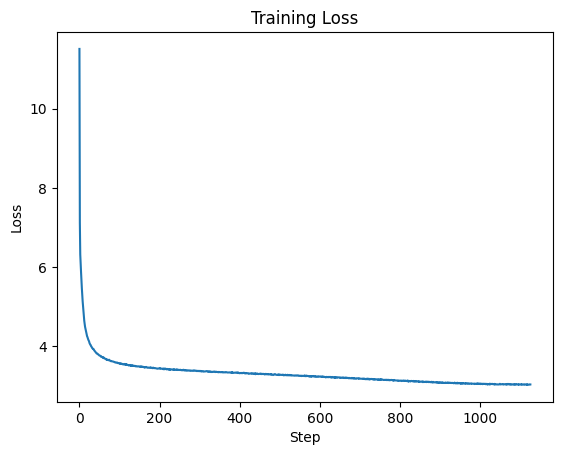

In [24]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [25]:
import orbax.checkpoint as orbax
import shutil
from pathlib import Path

home = Path.home()
checkpoint_path = os.path.join(str(home), "checkpoints")

# make sure the folder is empty and usable
shutil.rmtree(checkpoint_path, ignore_errors=True)

checkpointer = orbax.PyTreeCheckpointer()
train_state = nnx.state(model)
checkpointer.save(checkpoint_path, train_state)

In [26]:
model = nnx.eval_shape(lambda: create_model(rngs=nnx.Rngs(0)))
state = nnx.state(model)
checkpointer = orbax.PyTreeCheckpointer()
state = checkpointer.restore(checkpoint_path, item=state)
nnx.update(model, state)

generated_text = model.generate_text(
    seqlen//10, start_tokens
)
print(f"Restored model generated text:\n{generated_text}")

/root/prac/.venv/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Once upon a time, the only way to be sure that the person who has the most money is the one who has the most money is the one who has the most money. The person who has the most money is the one who has the most money.

If you have a lot of money, you will have a lot of people who have the most money. If you have a lot of money, you will have a lot of people who have the most money.

If you have a lot of money,Restored model generated text:
Once upon a time, the only way to be sure that the person who has the most money is the one who has the most money is the one who has the most money. The person who has the most money is the one who has the most money.

If you have a lot of money, you will have a lot of people who have the most money. If you have a lot of money, you will have a lot of people who have the most money.

If you have a lot of money,
